In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets

In [2]:
X, y = datasets.load_diabetes(return_X_y=True)
print("Computing regularization path using the LARS ...")
alphas, active, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)
print(active)
eps = np.finfo(float).eps
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

Computing regularization path using the LARS ...
.[2, 8, 3, 1, 9, 4, 7, 5, 0, 6]


In [5]:
def scale(x):
    mean = x.mean(axis=0, keepdims=True)
    stdev = x.std(axis=0, keepdims=True, ddof=0)
    return np.divide(np.subtract(x, mean), stdev)

X_ = X.copy()  # scale(X)
y_ = y.copy()  #  - np.mean(y)
n, p = X_.shape
beta = np.zeros(p)

r = y.copy()
corr = X_.T @ r
best_feat = np.argmax(np.abs(corr))
A = [best_feat]
beta_path = np.zeros((p, 1))

while True: 
    d = np.zeros(p)
    d[A] = np.linalg.inv(X[:, A].T @ X[:, A]) @ X[:, A].T @ r
    alpha = 1.0
    for j in range(p):
        if j not in A and beta[j] == 0:
            alpha_temp = dict()
            alpha_temp['+'] = (corr[j]  - corr[best_feat]) / (X_[:, j].T @ X_[:, A] @ d[A] - X_[:, best_feat].T @ X_[:, A] @ d[A])
            alpha_temp['-'] = (corr[j]  + corr[best_feat]) / (X_[:, j].T @ X_[:, A] @ d[A] + X_[:, best_feat].T @ X_[:, A] @ d[A])
            
            for key in alpha_temp.keys():
                if alpha_temp[key] <= 0.0:
                    alpha_temp[key] = np.inf

                if alpha_temp[key] <= alpha:
                    alpha = alpha_temp[key]
                    best_feat_temp = j
        
        elif beta[j] != 0 and j in A:
            if d[j] != 0:
                alpha_temp = -beta[j] / d[j]
                if alpha_temp <= alpha and alpha_temp >= 0.0:
                    alpha = alpha_temp
                    best_feat_temp = -j
    
    beta = beta + alpha * d  
    beta_path = np.concatenate((beta_path, beta.reshape(-1, 1)), axis=1)
    
    if alpha == 1.0:
        break
        
    if best_feat_temp < 0:
        A = [k for k in A if k != np.abs(best_feat_temp)]
        best_feat = A[0]
        
    else:
        A.append(best_feat_temp)
        best_feat = best_feat_temp
        
    
    r = r - alpha * (X_ @ d)
    corr = X_.T @ r

print(A)

[2, 8, 3, 1, 9, 4, 7, 5, 0, 6]


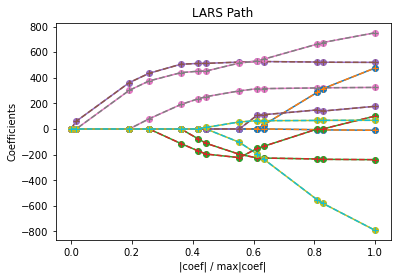

In [6]:
xx2 = np.sum(np.abs(beta_path.T), axis=1)
xx2 /= xx2[-1]
for i in range(p):
    plt.plot(xx2, beta_path[i, :], 'o-', label='beta_' + str(i + 1))
    plt.plot(xx, coefs[i, :], '+--', label='beta_' + str(i + 1))


ymin, ymax = plt.ylim()
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LARS Path')
# plt.legend()
plt.axis('tight')
# print(coefs)
# print(beta_path)
plt.show()